# Reproducing MCCD's Experiments

In [2]:
from functools import partial
from io import StringIO

from surface_sim.setups.setup import SetupDict

from mccd.random_clifford_circuit import *
from surface_sim.setups import CircuitNoiseSetup
from surface_sim.models import CircuitNoiseModel, BiasedCircuitNoiseModel
from surface_sim import Detectors, Setup
from surface_sim.experiments import schedule_from_circuit, experiment_from_schedule
import time
import stim

from pathlib import Path
import stim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
import itertools
import shelve
from surface_sim.layouts import rot_surface_codes

from pymatching import Matching as MWPM
from mle_decoder import MLEDecoder as MLE
from stimbposd import BPOSD
from sklearn.metrics import accuracy_score


## Baseline Decoders

- MWPM. We use the open-source library PyMatching with the noise model used for data generation as detailed in the ‘Experimentally motivated noise model’ subsection.

- BP-OSD. We use the open-source library stimbposd. We use the exact noise model used for data generation and set the maximal belief propagation iterations to 20.

- MLE. We use the algorithm developed and implemented as in ref. 14.

### Notes

All baselines have PyPI packages.

```
pymatching
mle-decoder
stimbposd
```

In [2]:
DECODER_BASELINES = {
    'BPOSD': partial(BPOSD, max_bp_iters=20),
    'MLE': MLE,
    'MWPM': MWPM,
}

## Basic Gates & Surface Code

MCCD uses I, X, Y, Z, H (single qubit gates) and CX (two qubit gates).

MCCD uses Rotated Surface Code.

surface-sim supports I, X, Z for rotated gates and I, H, X, Z for unrotated gates.

### Notes

We use the gates which `surface-sim` supports.

In [3]:
from surface_sim.circuit_blocks.rot_surface_code_css import gate_to_iterator
print('Rotated', gate_to_iterator.keys())
from surface_sim.circuit_blocks.unrot_surface_code_css import gate_to_iterator
print('Unrotated', gate_to_iterator.keys())
ROT_GATES = list('IXZ')
UNR_GATES = list('IHXZ')
MCCD_GATES = ['I', 'X', 'Y', 'Z', 'H']

Rotated dict_keys(['TICK', 'I', 'S', 'X', 'Z', 'CX', 'CNOT', 'R', 'RZ', 'RX', 'M', 'MZ', 'MX'])
Unrotated dict_keys(['TICK', 'I', 'S', 'H', 'X', 'Z', 'CX', 'CNOT', 'R', 'RZ', 'RX', 'M', 'MZ', 'MX'])


In [4]:
def to_stim_circuit(mccd_circuit):
    """Convert a MCCD circuit to stimuli circuit
    Args:
        mccd_circuit: MCCD circuit

    Returns:
        A stimuli circuit
    """
    res = stim.Circuit()
    # Must have R and M. Error inactive layout.
    for n in range(mccd_circuit.n_logical_qubits):
        res.append('R', [n])

    for name, timestep, qubits in mccd_circuit:
        res.append(name, qubits)
        # No need to add TICK here. surface-sim will add for us.

    for n in range(mccd_circuit.n_logical_qubits):
        res.append('M', [n])

    return res

def print_random_circuit(c: RandomCliffordCircuit):
    return list(c)

def dict_product(input_dict):
    keys = input_dict.keys()
    value_lists = input_dict.values()

    # 使用itertools.product生成所有值的组合
    value_combinations = itertools.product(*value_lists)

    # 将每个值的组合与键配对，生成字典列表
    for combo in value_combinations:
        yield dict(zip(keys, combo))

def run_decoder(name: str, circuit: stim.Circuit, shots: int):
    """Runs decoder on the given circuit

    Args:
        name: decoder name
        circuit: circuit to run
        shots: number of shots

    Returns:
        A dict containing the decoder metrics.
    """
    method = DECODER_BASELINES[name](circuit.detector_error_model())
    sampler = circuit.compile_detector_sampler()
    syndrome, labels = sampler.sample(shots=shots, separate_observables=True)
    begin = time.time_ns()
    predictions = method.decode_batch(syndrome)
    end = time.time_ns()
    logical_accuracy = accuracy_score(labels, predictions)
    walltime_seconds = (end - begin) / 1e9
    return dict(
        decoder=name,
        logical_accuracy=logical_accuracy,
        walltime_seconds=walltime_seconds,
    )

def compile_to_physical(log_cir: stim.Circuit, distance: int,
                        rotated=True, noise_prob: float = 1e-3) -> stim.Circuit:
    """Compile a logical circuit to physical one with the average depolarizing noise model.

    Args:
        log_cir: logical circuit
        distance: distance between qubits
        rotated: rotated code or unrotated code.
        noise_prob: average depolarizing noise probability

    Returns:
        The compiled logical circuit.
    """
    if rotated:
        from surface_sim.circuit_blocks.rot_surface_code_css import gate_to_iterator
        from surface_sim.layouts import rot_surface_codes
        layouts = rot_surface_codes(log_cir.num_qubits, distance=distance)
    else:
        from surface_sim.circuit_blocks.unrot_surface_code_css import gate_to_iterator
        from surface_sim.layouts import unrot_surface_codes
        layouts = unrot_surface_codes(log_cir.num_qubits, distance=distance)

    setup = CircuitNoiseSetup()
    setup.set_var_param("prob", noise_prob)
    model = CircuitNoiseModel.from_layouts(setup, *layouts)
    detectors = Detectors.from_layouts("pre-gate", *layouts)
    schedule = schedule_from_circuit(log_cir, layouts, gate_to_iterator)
    phy_cir: stim.Circuit = experiment_from_schedule(
        schedule, model, detectors, anc_reset=True
    )
    return phy_cir


def random_mirror_symmetric_clifford(circuit_index: str, depth: int,
                                     rotated=True) -> stim.Circuit:
    """Generate a random mirror symmetric clifford circuit (Type I or Type II)

    Args:
        circuit_index: circuit index
        depth: circuit depth before mirroring.
        rotated: rotated code or unrotated code.

    Returns:
        The generated clifford circuit
    """
    assert circuit_index in ['3', '4']
    logical_class = TypeICircuit if circuit_index == '3' else TypeIICircuit
    n_logical_qubits = 2 if circuit_index == '4' else 1

    random_circuit = logical_class(
        n_logical_qubits=n_logical_qubits,
        circuit_index=circuit_index,
        depth=depth,
        single_qubit_gate_list=ROT_GATES if rotated else ROT_GATES,
    )
    random_circuit.sample_circuit()
    return to_stim_circuit(random_circuit)


def generate_circuit(distance: int, depth: int, circuit_index: str, noise_prob: float):
    log_cir = random_mirror_symmetric_clifford(circuit_index, depth)
    phy_cir: stim.Circuit = compile_to_physical(log_cir, distance, noise_prob=noise_prob)
    config = dict(distance=distance, depth=depth, circuit_type_index=circuit_index)
    return phy_cir, log_cir, config


## Circuit Depths

From released source_data.zip, Type I circuits have depths:

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])

Type II circuits have depths:

array([ 4,  8, 12, 16, 20, 24, 28, 32, 36])


## Noise Model

1. The experimentally motivated noise model, which is the one used in all numerical results in the main text. See Methods section for details.
2. A simplified noise model that replaces all Pauli noise channels, both single-qubit and two-qubit, in the experiment-motivated noise model with a depolarizing noise model using an average noise strength. The probabilities of idling error, reset error, and measurement error remain the same. We refer to this as the average depolarizing noise model.
3. A stronger depolarizing noise model in which the strengths of all noise channels, including single- and two-qubit depolarization, idling error, reset error, and measurement error probability, are doubled compared to the average depolarizing noise model. We refer to this as the double depolarizing noise model.

### Note

1 can only be implemented with `stim`'s builtin instructions like `PAULI_CHANNEL_2` to fill all the parameters.
Or as a custom `Model` of `surface-sim`.

This noise model is used in Results (Fig. 4 & Fig. 5).

2 & 3 can be implemented with `surface-sim`'s `CircuitNoiseModel` with a single `prob` parameter.

The paper does not release the value of the average noise probability. We set it to 1e-3.

### Details of experimentally motivated noise model.

For the numerical studies presented in the ‘Results’ section, we use the stim package for simulation. We consider a circuit-level noise model motivated by the current experimental capability of neutral atom array-based quantum computers. Specifically, we use a circuit-level noise model that includes the following physical noises:

• Each two-qubit physical gate is followed by a two-qubit Pauli noise channel with probability [0.0005, 0.00175, 0.000625, 0.0005, 0, 0, 0, 0.00175, 0, 0, 0, 0.000625, 0, 0, 0.00125]

• Each single-qubit physical gate is followed by a single-qubit depolarizing model with probability [0.0001, 0.0001, 0.0001]

• On a physical level, the atoms are moved to achieve flexible connectivity between different physical qubits. This comes at the cost of having idling error due to the extra time taken during the physical qubit movement, which is captured as a Pauli noise channel with probability [4 × 10−7, 4 × 10−7, 1.6 × 10−6]. This error channel is applied when physical qubit movement happens.

• Resetting a physical qubit has a bit flip error probability of P = 0.002.

• Measuring a physical qubit has a bit flip error probability of P = 0.002.



### Shots & Repeat
We evaluate each decoder over 20 independent runs. In each run, we randomly sample 1,000 syndrome trajectories from Type I/II circuits and average them to obtain a run-level performance estimate. We report the mean across the 20 runs, with error bars showing s.e.m.


In [11]:
num_shots = 1000
trial = 20
noise_prob = 1e-3

def get_figure4_settings():
    distance = [3, 5]
    depth = [ 2,  4,  6,  8, 10, 12, 14, 16, 18]
    # Type I one qubit. Type II two qubits.
    circuit_index = ['3']

    return dict_product(dict(
        distance=distance,
        depth=depth,
        circuit_index=circuit_index,
        noise_prob=[noise_prob],
    ))

def get_figure5_settings():
    distance = [3, 5]
    depth = [ 4,  8, 12, 16, 20, 24, 28, 32, 36]
    # Type I one qubit. Type II two qubits.
    circuit_index = ['4']

    return list(dict_product(dict(
        distance=distance,
        depth=depth,
        circuit_index=circuit_index,
        noise_prob=[noise_prob],
    )))

figure4_settings = get_figure4_settings()
figure5_settings = get_figure5_settings()

In [12]:
def get_syndrome_labels(circuit: stim.Circuit, shots: int, depth: int, n_logical_qubits: int):
    sampler = circuit.compile_detector_sampler()
    syndrome, labels = sampler.sample(shots=shots, separate_observables=True)
    print(syndrome.shape, labels.shape)
    syndrome = syndrome.reshape((shots, n_logical_qubits, depth * 2, -1))
    return syndrome, labels

In [13]:
def generate_bench_circuits(baseline_settings):
    """Generate the benchmark circuits
    Args:
        baseline_settings: baseline settings

    Returns:
        The generated benchmark circuits
    """

    def gen_circuit_to_str(**params):
        phy_cir, log_cir, config = generate_circuit(**params)
        return str(phy_cir), str(log_cir), config

    def tasks():
        for params in baseline_settings:
            yield delayed(gen_circuit_to_str)(**params)

    res = Parallel(n_jobs=-1, verbose=1)(tasks())
    print('done')
    return res

fig4_circuits = generate_bench_circuits(figure4_settings)
fig5_circuits = generate_bench_circuits(figure5_settings)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not i

done
done


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    5.1s finished


In [14]:
# Must save the circuits for fair comparison with MCCD.
# Filename format: d3_c3_D1, distance=3, circuit_index=3, depth=1

def save_circuits(subdir, bench_circuits):
    save_dir = Path('./data/bench/circuits') / subdir
    save_dir.mkdir(parents=True, exist_ok=True)

    for phy_cir, log_cir, config in bench_circuits:
        distance, depth, circuit_index = config['distance'], config['depth'], config['circuit_type_index']
        filename = f'd{distance}_c{circuit_index}_D{depth}'
        (save_dir / (filename + '_phy')).with_suffix('.stim').write_text(phy_cir)
        (save_dir / (filename + '_log')).with_suffix('.stim').write_text(log_cir)

In [15]:
def run_decoder_tasks(bench_circuits, df_name):
    """Run all the baseline decoders on the benchmark circuit.

    Args:
        bench_circuits: Benchmark circuits.
        df_name: Name of the dataframe file.

    Returns:
        The result dataframe.
    """
    def run_decoder_plus(config, cir_str, **kwargs):
        cir = stim.Circuit.from_file(StringIO(cir_str))
        kwargs['circuit'] = cir
        res = run_decoder(**kwargs)
        res.update(config)
        return res

    def tasks():
        for phy_cir, _, config in bench_circuits:
            for decoder in DECODER_BASELINES.keys():
                for t in range(trial):
                    yield delayed(run_decoder_plus)(config, phy_cir,
                                                    name=decoder, shots=num_shots)

    bench_result = Parallel(n_jobs=-1, verbose=1)(tasks())

    df = pd.DataFrame.from_records(bench_result)
    df = pd.melt(df, id_vars=['decoder', 'distance', 'depth', 'circuit_type_index'],
             value_vars=['walltime_seconds', 'logical_accuracy'],
             var_name='metric',
             value_name='value')

    filename = Path(f'./data/result/{df_name}.csv')
    filename.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(filename, index=False)
    print('done')
    return df


In [16]:
df4 = run_decoder_tasks(fig4_circuits, 'reproduce_fig4')

df5 = run_decoder_tasks(fig5_circuits, 'reproduce_fig5')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Restricted license - for non-production use only - expires 2027-11-29
Restricted license - for non-production use only - expires 2027-11-29
Restricted license - for non-production use only - expires 2027-11-29
Restricted license - for non-production use only - expires 2027-11-29
Restricted license - for non-production use only - expires 2027-11-29
Restricted license - for non-production use only - expires 2027-11-29
Restricted license - for non-production use only - expires 2027-11-29
Restricted license - for non-production use only - expires 2027-11-29
Restricted license - for non-production use only - expires 2027-11-29
Restricted license - for non-production use only - expires 2027-11-29


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 908 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   34.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


done


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 550 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 900 tasks      | elapsed:  3.5min


done


[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  5.5min finished


## Visualization

In [5]:
hue_order = 'MLE BPOSD MWPM'.split()

### Results on Type I Circuits

In [4]:
df4 = pd.read_csv('./data/result/reproduce_fig4.csv')

Text(0.5, 1.0, 'd = 5, Type I circuits, Logical Accuracy')

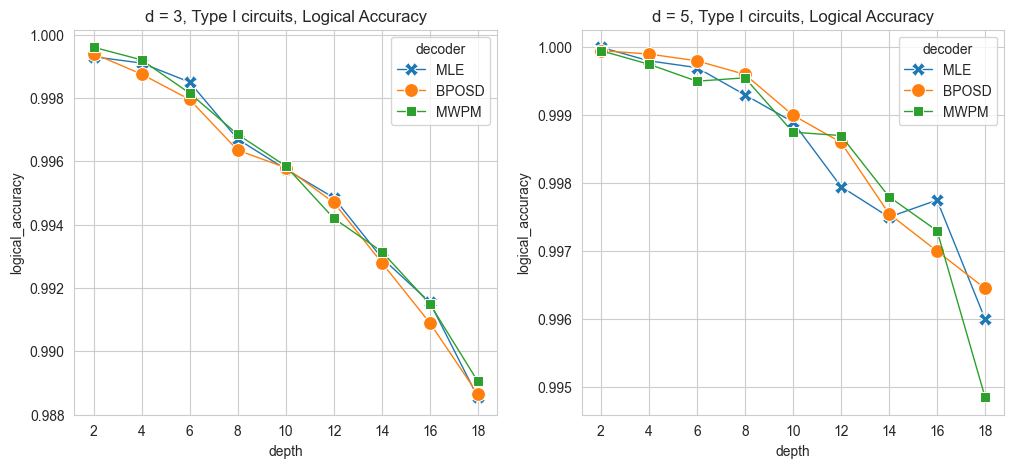

In [6]:
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
sns.lineplot(df4[(df4.metric == 'logical_accuracy') & (df4.distance == 3)], x='depth', y='value', hue='decoder',hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('logical_accuracy')
plt.title('d = 3, Type I circuits, Logical Accuracy')
plt.ylim(0.5, 1.0)

ax=plt.subplot(122)
sns.lineplot(df4[(df4.metric == 'logical_accuracy') & (df4.distance == 5)], x='depth', y='value', hue='decoder',hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('logical_accuracy')
plt.title('d = 5, Type I circuits, Logical Accuracy')
plt.ylim(0.6, 1.0)


Compared with Fig. 4, the range of decrease is much smaller for Type I Circuits.
However, our decrease ranges on Type I Circuits are still smaller than on Type II Circuits, which is similar to Fig. 4 and Fig. 5.

The performances of different decoders are also closer than Fig. 4.

The relative order is not well-preserved because they are nearly the same for each depth.

Text(0.5, 1.0, 'd = 5, Type I circuits, Wall time')

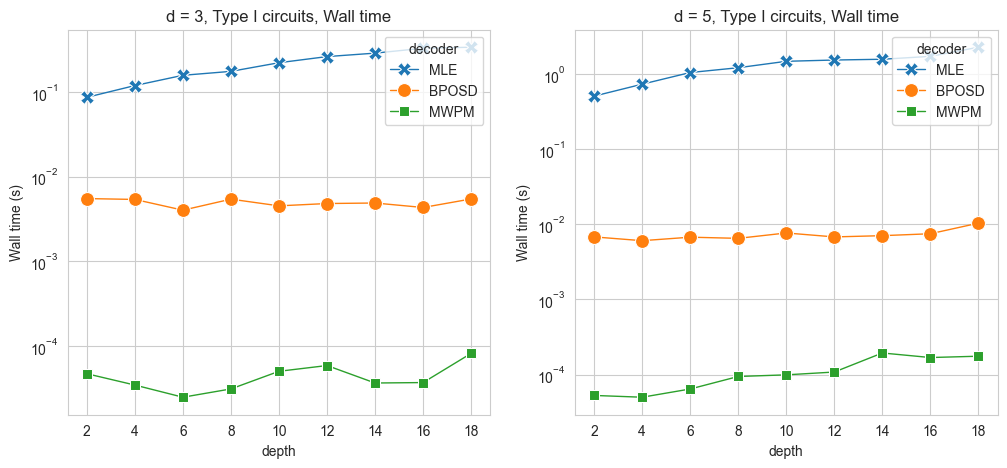

In [25]:
plt.figure(figsize=(12,5))
ax=plt.subplot(121)

sns.lineplot(df4[(df4.metric == 'walltime_seconds') & (df4.distance == 3)], x='depth', y='value', hue='decoder', hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('Wall time (s)')
plt.yscale('log')
plt.title('d = 3, Type I circuits, Wall time')

ax=plt.subplot(122)
sns.lineplot(df4[(df4.metric == 'walltime_seconds') & (df4.distance == 5)], x='depth', y='value', hue='decoder', hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('Wall time (s)')
plt.yscale('log')
plt.title('d = 5, Type I circuits, Wall time')

Compared with Fig. 4, our wall time in seconds are faster for Type I but slower for Type II.

The trend of longer time for deeper circuits are less clear than Fig. 4.

The relative order of baseline methods is preserved: MLE > BPOSD > MWPM.

### Results on Type II Circuits

In [26]:
df5 = pd.read_csv('./data/result/reproduce_fig5.csv')

Text(0.5, 1.0, 'd = 5, Type II circuits, Logical Accuracy')

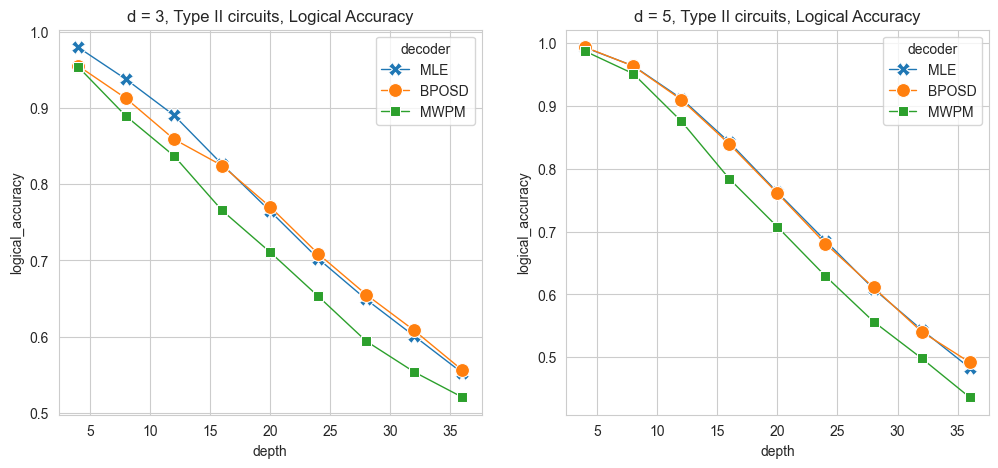

In [27]:
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
sns.lineplot(df5[(df5.metric == 'logical_accuracy') & (df5.distance == 3)], x='depth', y='value', hue='decoder', hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('logical_accuracy')

plt.title('d = 3, Type II circuits, Logical Accuracy')
ax=plt.subplot(122)
sns.lineplot(df5[(df5.metric == 'logical_accuracy') & (df5.distance == 5)], x='depth', y='value', hue='decoder', hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('logical_accuracy')

plt.title('d = 5, Type II circuits, Logical Accuracy')

Compared to Fig. 5, the relative order of decoders is preserved: MLE >= BPOSD >= MWPM.

The range of logical accuracy as the depth increases is also very close to that of Fig. 5.

The lower bounds of logical accuracy in Fig. 5 are about 10% better than ours for both d = 3 and d = 5.

The upper bounds of both ours and Fig. 5 are nearly the same: close to 100%.


Text(0.5, 1.0, 'd = 5, Type II circuits, Wall time')

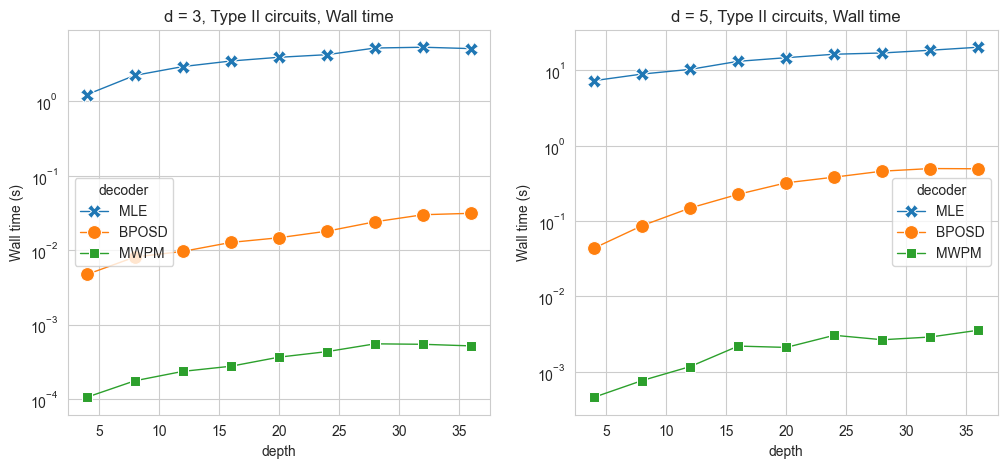

In [28]:
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
sns.lineplot(df5[(df5.metric == 'walltime_seconds') & (df5.distance == 3)], x='depth', y='value', hue='decoder', hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('Wall time (s)')
plt.yscale('log')
# plt.ylim(1e-3, 10)
plt.title('d = 3, Type II circuits, Wall time')
ax=plt.subplot(122)
sns.lineplot(df5[(df5.metric == 'walltime_seconds') & (df5.distance == 5)], x='depth', y='value', hue='decoder', hue_order=hue_order,
             errorbar=None, style='decoder', markers=True, dashes=False, markersize=10, linewidth=1, ax=ax)
plt.ylabel('Wall time (s)')
plt.yscale('log')
# plt.ylim(1e-3, 10)
plt.title('d = 5, Type II circuits, Wall time')

Again, the relative order is preserved: MLE > BPOSD > MWPM.

The trend of increasing wall time in seconds is also nearly the same.

The absolute ranges of wall time for each decoder are quite different.

## Conclusion

### Pros
1. Overall trends are reproduced.
    - Increasing wall time as the depth increases.
    - Decreasing logical accuracy as the depth increases.
2. Overall relative orders of different decoders are reproduced.
    - For logical accuracy, MLE > BPOSD > MWPM.
    - For wall time, MLE > BPOSD > MWPM.

### Cons
1. Absolute value ranges are not reproduced.
2. MCCD is not reproduced.
3. The experimental noise model is not reproduced.